In [91]:
#Import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Load the data
Selected = pd.read_csv('FeatureSelection.csv')

# Establish potential_total_value_of_award as the target variable
y = 'potential_total_value_of_award'

# Establish the features
features = Selected.drop(y, axis =1)
features = features.dropna() 
# Look at the dataframe
Selected.head()

,potential_total_value_of_award,recipient_state_name,extent_competed_code,product_or_service_code,award_type_code,program_activities_funding_this_award,woman_owned_business,minority_owned_business,other_minority_owned_business,contracting_officers_determination_of_business_size_code
0,69560.96,MASSACHUSETTS,G,J066,B,00K7: RESEARCH: SAFE AND SUSTAINABLE WATER RES...,f,f,f,O
1,2692394.40,TEXAS,A,R429,C,0000: UNKNOWN;0044: CIVIL ENFORCEMENT;0050: CO...,f,f,f,O
2,477626.28,MARYLAND,D,F108,C,00D2: SUPERFUND: REMEDIAL,f,f,f,S
3,51073.44,GEORGIA,A,R429,C,00D2: SUPERFUND: REMEDIAL,f,f,f,O
4,9799696.81,VIRGINIA,A,F999,C,00D2: SUPERFUND: REMEDIAL,f,t,f,S


In [92]:
# Identifying binary, low and high cardinality features
binary_columns = features.nunique()[features.nunique() == 2].index.tolist()
low_cardinality_columns = features.nunique()[(features.nunique() > 2) & (features.nunique() <= 10)].index.tolist()
high_cardinality_columns = features.nunique()[features.nunique() > 10].index.tolist()

# Label encode the binary columns
for col in binary_columns:
    features[col] = features[col].map({'f': 0, 't': 1})

# Frequency encode high cardinality columns
for col in high_cardinality_columns:
    frequency = features[col].value_counts(normalize=True)
    features[col] = features[col].map(frequency)

# One hot encode low cardinality columns
for col in low_cardinality_columns:
    dummies = pd.get_dummies(features[col], prefix=col)
    features = pd.concat([features, dummies], axis=1)
    features.drop(col, axis=1, inplace=True)

#combine 
features[y] = Selected[y] 

#DF 
features.head()


,recipient_state_name,product_or_service_code,program_activities_funding_this_award,woman_owned_business,minority_owned_business,other_minority_owned_business,contracting_officers_determination_of_business_size_code,extent_competed_code_A,extent_competed_code_B,extent_competed_code_C,extent_competed_code_D,extent_competed_code_F,extent_competed_code_G,extent_competed_code_NDO,award_type_code_A,award_type_code_B,award_type_code_C,award_type_code_D,potential_total_value_of_award
0,0.100708,0.035021,0.019597,0,0,0,NaN,False,False,False,False,False,True,False,False,True,False,False,69560.96
1,0.023226,0.059336,0.000181,0,0,0,NaN,True,False,False,False,False,False,False,False,False,True,False,2692394.40
2,0.067683,0.146979,0.119942,0,0,0,NaN,False,False,False,True,False,False,False,False,False,True,False,477626.28
3,0.019960,0.059336,0.119942,0,0,0,NaN,True,False,False,False,False,False,False,False,False,True,False,51073.44
4,0.197060,0.062239,0.119942,0,1,0,NaN,True,False,False,False,False,False,False,False,False,True,False,9799696.81


In [93]:
features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5511 entries, 0 to 5944
Data columns (total 19 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   recipient_state_name                                      5511 non-null   float64
 1   product_or_service_code                                   5511 non-null   float64
 2   program_activities_funding_this_award                     5511 non-null   float64
 3   woman_owned_business                                      5511 non-null   int64  
 4   minority_owned_business                                   5511 non-null   int64  
 5   other_minority_owned_business                             5511 non-null   int64  
 6   contracting_officers_determination_of_business_size_code  0 non-null      float64
 7   extent_competed_code_A                                    5511 non-null   bool   
 8   extent_competed_code_B 

In [95]:
features = features.drop(columns=['contracting_officers_determination_of_business_size_code']) 

In [96]:
#Set up model 
X = features.drop(y, axis = 1)
Y = features[y]

# Split the data into a training set and a test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [97]:
#Random Forest 
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 0) 

# Fit the model
rf_model.fit(X_train, Y_train)

#feature importance
importances = rf_model.feature_importances_

# Sort the feature importances
features_dictionary = dict(zip(X_train.columns, importances))
sorted_features = sorted(features_dictionary.items(), key=lambda x: x[1], reverse=True)
sorted_indices = np.argsort(importances)[::-1]

# Print the feature importances
print(sorted_features)

[('program_activities_funding_this_award', 0.3365696079876865), ('recipient_state_name', 0.1988396362331978), ('product_or_service_code', 0.18622427851445095), ('extent_competed_code_A', 0.08601446635744421), ('extent_competed_code_D', 0.05814738091813538), ('award_type_code_D', 0.04490692975962369), ('woman_owned_business', 0.03910866412773198), ('minority_owned_business', 0.02492135417955308), ('extent_competed_code_B', 0.014135509308427269), ('award_type_code_C', 0.0028429524527656667), ('award_type_code_B', 0.002377367107082809), ('other_minority_owned_business', 0.0019788010657202657), ('extent_competed_code_C', 0.0018168058579256267), ('award_type_code_A', 0.0012210143437027354), ('extent_competed_code_G', 0.0005462898447495079), ('extent_competed_code_NDO', 0.00020975952756998028), ('extent_competed_code_F', 0.00013918241423270392)]


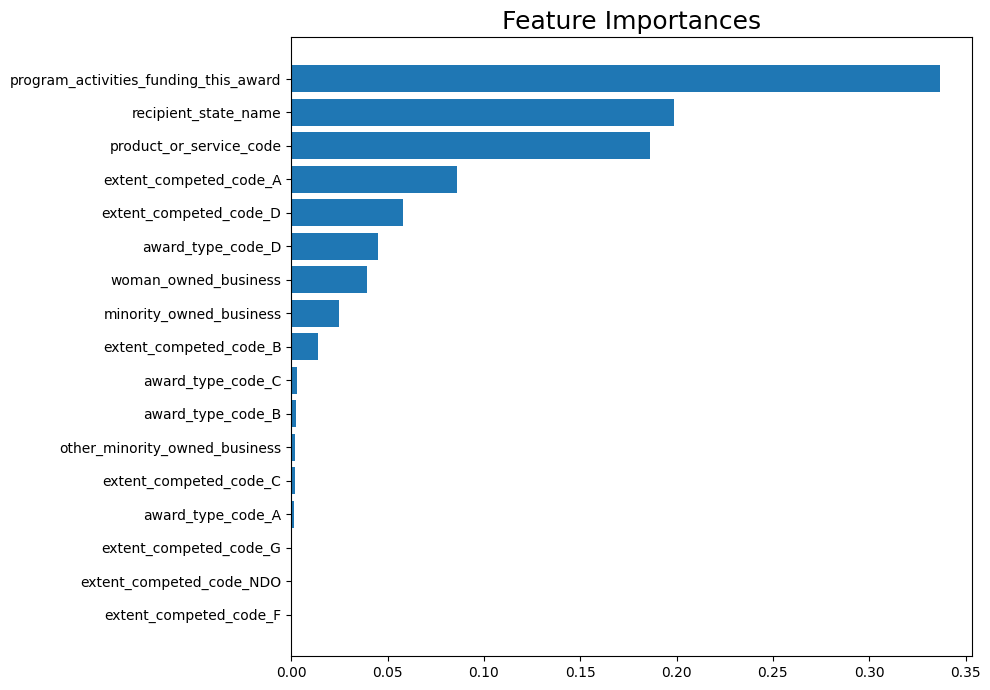

In [98]:
#Display 
plt.figure(figsize=(10, 7))
plt.title('Feature Importances', fontsize=18)
plt.barh(range(X_train.shape[1]), importances[sorted_indices][::-1], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_indices][::-1])
plt.tight_layout()
plt.show()

In [99]:
# Make predictions on the test set
Y_pred = rf_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(Y_test, Y_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"R-squared: {r_squared}")
print(f"RMSE: {rmse}")

R-squared: -1.0051218902033567
RMSE: 7337550.953447666


In [100]:
# Initialize the GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=0)

# Fit the model
gb_model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred_gb = gb_model.predict(X_test)

# Calculate R-squared and RMSE for GradientBoostingRegressor
r_squared_gb = r2_score(Y_test, Y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(Y_test, Y_pred_gb))

print(f"Gradient Boosting R-squared: {r_squared_gb}")
print(f"Gradient Boosting RMSE: {rmse_gb}")

Gradient Boosting R-squared: -0.4294070124479883
Gradient Boosting RMSE: 6195247.98533668


In [101]:
#Filter the dataset
owned_business_filter = (features['woman_owned_business'] == 1) | \
                        (features['minority_owned_business'] == 1) | \
                        (features['other_minority_owned_business'] == 1)

filtered_features = features[owned_business_filter]

#Split into features and target
X_filtered = filtered_features.drop('potential_total_value_of_award', axis=1)
Y_filtered = filtered_features['potential_total_value_of_award']


#Split the filtered data into training and testing sets
X_train_filtered, X_test_filtered, Y_train_filtered, Y_test_filtered = train_test_split(
    X_filtered, Y_filtered, test_size=0.2, random_state=42)

In [103]:
rf_model_filtered = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model_filtered.fit(X_train_filtered, Y_train_filtered)

Y_pred_rf_filtered = rf_model_filtered.predict(X_test_filtered)

r_squared_rf_filtered = r2_score(Y_test_filtered, Y_pred_rf_filtered)
rmse_rf_filtered = np.sqrt(mean_squared_error(Y_test_filtered, Y_pred_rf_filtered))

In [104]:
print(f"Filtered Random Forest R-squared: {r_squared_rf_filtered}, RMSE: {rmse_rf_filtered}")

Filtered Random Forest R-squared: -1.1887779232036557, RMSE: 7204546.408069949


In [105]:
gb_model_filtered = GradientBoostingRegressor(n_estimators=100, random_state=0)
gb_model_filtered.fit(X_train_filtered, Y_train_filtered)

Y_pred_gb_filtered = gb_model_filtered.predict(X_test_filtered)

r_squared_gb_filtered = r2_score(Y_test_filtered, Y_pred_gb_filtered)
rmse_gb_filtered = np.sqrt(mean_squared_error(Y_test_filtered, Y_pred_gb_filtered))

In [106]:
print(f"Filtered Gradient Boosting R-squared: {r_squared_gb_filtered}, RMSE: {rmse_gb_filtered}")

Filtered Gradient Boosting R-squared: -4.7293806933748055, RMSE: 11656270.936048549


In [108]:
#Eliminate non-essential features based on the results of the feature importance analysis
features_to_keep = [feature[0] for feature in sorted_features if feature[1] > 0.01]

print(f"Features to keep: {features_to_keep}")

#Rerun the model with the reduced feature set
X_filtered_reduced = X_filtered[features_to_keep]
X_train_filtered_reduced, X_test_filtered_reduced, Y_train_filtered, Y_test_filtered = train_test_split(
    X_filtered_reduced, Y_filtered, test_size=0.2, random_state=42)

rf_model_filtered_reduced = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model_filtered_reduced.fit(X_train_filtered_reduced, Y_train_filtered)

Y_pred_rf_filtered_reduced = rf_model_filtered_reduced.predict(X_test_filtered_reduced)

r_squared_rf_filtered_reduced = r2_score(Y_test_filtered, Y_pred_rf_filtered_reduced)

rmse_rf_filtered_reduced = np.sqrt(mean_squared_error(Y_test_filtered, Y_pred_rf_filtered_reduced))

print(f"Filtered Reduced Random Forest R-squared: {r_squared_rf_filtered_reduced}, RMSE: {rmse_rf_filtered_reduced}")

Features to keep: ['program_activities_funding_this_award', 'recipient_state_name', 'product_or_service_code', 'extent_competed_code_A', 'extent_competed_code_D', 'award_type_code_D', 'woman_owned_business', 'minority_owned_business', 'extent_competed_code_B']
Filtered Reduced Random Forest R-squared: -1.1762289717568155, RMSE: 7183863.75647495


In [109]:
# Initialize the GradientBoostingRegressor
gb_model_filtered_reduced = GradientBoostingRegressor(n_estimators=100, random_state=0)

# Fit the model
gb_model_filtered_reduced.fit(X_train_filtered_reduced, Y_train_filtered)

# Make predictions on the test set
Y_pred_gb_filtered_reduced = gb_model_filtered_reduced.predict(X_test_filtered_reduced)

# Calculate R-squared and RMSE for GradientBoostingRegressor
r_squared_gb_filtered_reduced = r2_score(Y_test_filtered, Y_pred_gb_filtered_reduced)
rmse_gb_filtered_reduced = np.sqrt(mean_squared_error(Y_test_filtered, Y_pred_gb_filtered_reduced))
                                   
print(f"Filtered Reduced Gradient Boosting R-squared: {r_squared_gb_filtered_reduced}, RMSE: {rmse_gb_filtered_reduced}")

Filtered Reduced Gradient Boosting R-squared: -3.8653232433791613, RMSE: 10741418.634900143
